In [2]:
import numpy as np
import matplotlib.pyplot as plt
# set the path so it can import the kmeans.py file
import sys
sys.path.append('ex3')
np.set_printoptions(threshold=np.inf)
data = np.load("mnist_all.npz")

In [3]:
def cluster_dist(c1, c2):
    return np.array([np.linalg.norm(x1 - x2) for x1 in c1 for x2 in c2]).min()


def singlelinkage(X, k):
    """
    :param X: numpy array of size (m, d) containing the test samples
    :param k: the number of clusters
    :return: a column vector of length m, where C(i) ∈ {1, . . . , k} is the identity of the cluster in which x_i has been assigned.
    """
    m, d = X.shape
    clusters = [np.array([i]) for i in range(m)]
    while len(clusters) > k:
        distances = np.array([[cluster_dist(clusters[i], clusters[j]) for j in range(len(clusters))] for i in range(len(clusters))])
        np.fill_diagonal(distances, np.inf)
        min_i, min_j = np.unravel_index(np.argmin(distances), distances.shape)
        clusters[min_i] = np.concatenate((clusters[min_i], clusters[min_j]))
        clusters.pop(min_j)
    res = np.zeros((m, 1))
    for i, c in enumerate(clusters):
        for x_index in c:
            res[x_index] = i
    return res

In [31]:
def initialize_centroids(X, k):
    """
    Initialize centroids by randomly selecting k data points from X
    """
    return X[np.random.choice(range(X.shape[0]), size=k)]


def get_distances(X, k, centroids):
    """
    Get the distance of each data point from each centroid
    """
    return np.array([np.linalg.norm(X - centroids[i], axis=1) for i in range(k)]).T



def assign_clusters(distances):
    """
    Assign each data point to the cluster with the nearest centroid
    """
    return np.argmin(distances, axis=1)


def compute_new_centroids(X, k, clusters):
    """
    Compute new centroids for each cluster by taking the mean of all data points in the cluster
    """
    return np.array([X[clusters == i].mean(axis=0) for i in range(k)])


def kmeans(X, k, t):
    """
    :param X: numpy array of size (m, d) containing the test samples
    :param k: the number of clusters
    :param t: the number of iterations to run
    :return: a column vector of length m, where C(i) ∈ {1, . . . , k} is the identity of the cluster in which x_i has been assigned.
    """
    centroids = initialize_centroids(X, k)
    clusters = None
    for _ in range(t):
        distances = get_distances(X, k, centroids)
        clusters = assign_clusters(distances)
        centroids = compute_new_centroids(X, k, clusters)

    return clusters.reshape((-1, 1))


In [26]:
def analyze_kmeans_unlabeld(k):
    X = np.concatenate([data[f'train{i}'] for i in range(10)])
    Y = np.concatenate(
        [np.full((data[f'train{i}'].shape[0], 1), i) for i in range(10)])
    
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    samples = np.array(X[indices][:1000])
    labels = Y[indices][:1000]

    kmeans_res = kmeans(samples, k, 20)

    clusters = np.empty((k,), dtype=object)
    for i in range(k):
        indices = np.where(kmeans_res == i)[0]
        clusters[i] = indices
    
    # clusters size 
    clsuters_size = np.array([len(cluster) for cluster in clusters])

    #  most common 
    real_labels_per_cluster = [[labels[i] for i in cluster] for cluster in clusters]
    most_common_label_in_cluster = []
    for real_labels in real_labels_per_cluster:
        if len(real_labels) > 0:
            most_common_label_in_cluster.append(max(real_labels, key=real_labels.count))
        else:
            most_common_label_in_cluster.append(-1)

    precent_of_most_common_label_in_cluster = [real_labels.count(
        most_common_label_in_cluster[i]) / clsuters_size[i] for i, real_labels in enumerate(real_labels_per_cluster)]

    errors = []
    for i in range(k):
        if clsuters_size[i] == 0:
            errors.append(0)
        else:
            errors.append(np.mean((np.array([most_common_label_in_cluster[i] for _ in range(
                clsuters_size[i])]).reshape(-1, 1)) != real_labels_per_cluster[i]))
                
    return [clsuters_size, most_common_label_in_cluster, precent_of_most_common_label_in_cluster, errors]

def analyze_single_linkage_unlabeld(k):
    X = np.concatenate([data[f'train{i}'] for i in range(10)])
    Y = np.concatenate([np.full((data[f'train{i}'].shape[0], 1), i) for i in range(10)])
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    samples = np.array(X[indices][:300])
    labels = Y[indices][:300]

    single_linkage_res = singlelinkage(samples, k)
    clusters = np.empty((k,), dtype=object)
    for i in range(k):
        indices = np.where(single_linkage_res == i)[0]
        clusters[i] = indices

    clsuters_size = np.array([len(cluster) for cluster in clusters])

    real_labels_per_cluster = [[labels[i]
                                for i in cluster] for cluster in clusters]
    most_common_label_in_cluster = []
    for real_labels in real_labels_per_cluster:
        if len(real_labels) > 0:
            most_common_label_in_cluster.append(
                max(real_labels, key=real_labels.count))
        else:
            most_common_label_in_cluster.append(-1)
    
    precent_of_most_common_label_in_cluster = [real_labels.count(most_common_label_in_cluster[i]) / clsuters_size[i] for i,real_labels in enumerate(real_labels_per_cluster)]
    # format the precent to 4 digits after the dot
    errors = []
    for i in range(k):
        if clsuters_size[i] == 0:
            errors.append(0)
        else:
            errors.append(np.mean((np.array([most_common_label_in_cluster[i] for _ in range(
                clsuters_size[i])]).reshape(-1, 1)) != real_labels_per_cluster[i]))
    
    table = [clsuters_size, most_common_label_in_cluster, precent_of_most_common_label_in_cluster, errors]
    return table  


In [27]:
def make_table(data, cols, rows, filename=None):
    local_data = data.copy()
    #  multply data[2] by 100 and only 2 digits after the dot
    local_data[2] = [f"{x*100:.2f}%" for x in local_data[2]]
    local_data[3] = [f"{x:.2f}" for x in local_data[3]]
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=local_data, colLabels=cols, rowLabels=rows, cellLoc = 'center', loc='center')
    plt.show()
    if filename is not None:
        fig.savefig(filename)

In [ ]:
rows = ["Cluster Size", "Most Common Label", "Precent of Most Common Label", "Error"]
cols = [f"Cluster {i}" for i in range(10)]
# k = 10
table = analyze_kmeans_unlabeld(10)
make_table(table, cols, rows, "1c_kmeans_table.png")
table = analyze_single_linkage_unlabeld(10)
make_table(table, cols, rows, "1d_single_linkage_table.png")



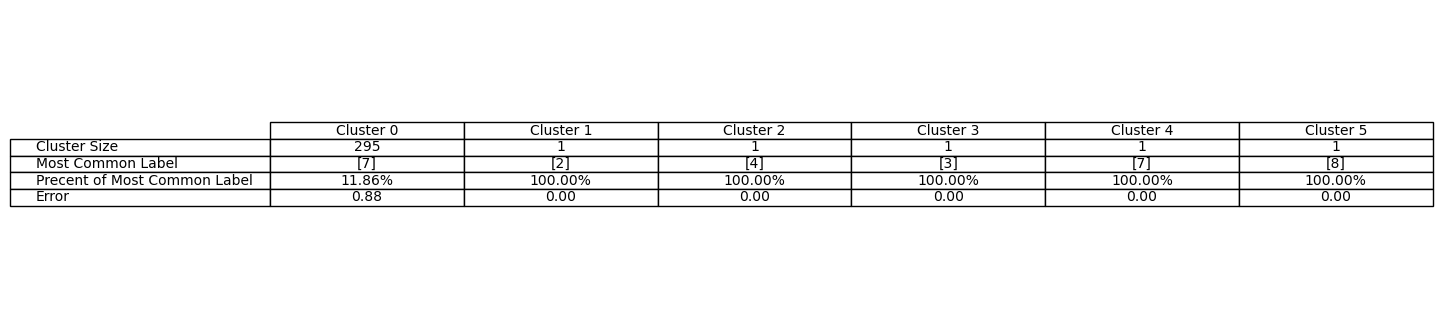

In [29]:
rows = ["Cluster Size", "Most Common Label", "Precent of Most Common Label", "Error"]
cols = [f"Cluster {i}" for i in range(6)]
# k = 6
# table = analyze_kmeans_unlabeld(6)
# make_table(table, cols, rows, "1e_kmeans_table_k_6.png")
table = analyze_single_linkage_unlabeld(6)
make_table(table, cols, rows, "1e_single_linkage_table_k_6.png")